# Research goal
We have a dynamical system that is described by the following evolution and measurement equations
\begin{equation}
    \begin{aligned}
        x_{t+1} &= a x_{t} + \epsilon \\
        y_{t} & = x_{t} + \nu \,,
    \end{aligned}
\end{equation}
where $ \epsilon $ and $ \nu $ are noise terms both normally distributed with zero mean and variances $ \sigma_{\epsilon} $ and $ \sigma_{\nu} $ respectively. Mathematically that iss
\begin{equation}
    \begin{aligned}
        \epsilon &\sim \mathcal{N} (E=\epsilon; 0, \sigma_{\epsilon}) \\
        \nu &\sim \mathcal{N} (N=\nu; 0, \sigma_{\nu}) \,,
    \end{aligned}
\end{equation}
__Note__: We assume that $ \sigma_{\epsilon} $ and $ \sigma_{\nu} $ are known.
Having collected a set of measurements $ \mathcal{Y} = \{ y_t | t=1, \dots, N \} $ we want to estimate the parameter $ a $ in the  evolution equation.

/home/yorgos/work_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 0	Loss: 4.094E+04
Epoch: 100	Loss: 4.784E+02
Epoch: 200	Loss: 6.913E+04
Epoch: 300	Loss: 2.647E+03
Epoch: 400	Loss: 1.213E+06
Epoch: 500	Loss: 1.202E+04
Epoch: 600	Loss: 4.105E+03
Epoch: 700	Loss: 6.792E+10
Epoch: 800	Loss: 1.492E+04
Epoch: 900	Loss: 2.356E+14
Epoch: 1000	Loss: 1.795E+03
Epoch: 1100	Loss: 8.817E+02
Epoch: 1200	Loss: 3.407E+10
Epoch: 1300	Loss: 4.340E+03
Epoch: 1400	Loss: 1.886E+04
Epoch: 1500	Loss: 3.683E+02
Epoch: 1600	Loss: 3.494E+06
Epoch: 1700	Loss: -1.256E+02
Epoch: 1800	Loss: 1.899E+04
Epoch: 1900	Loss: 2.201E+10
Epoch: 1999	Loss: 6.632E+16
AutoNormal.locs.a_param = Parameter containing:
tensor(1.0069, requires_grad=True)
AutoNormal.scales.a_param = 0.12021034210920334


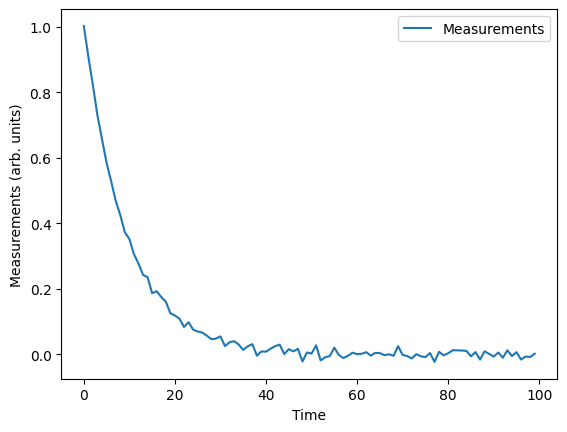

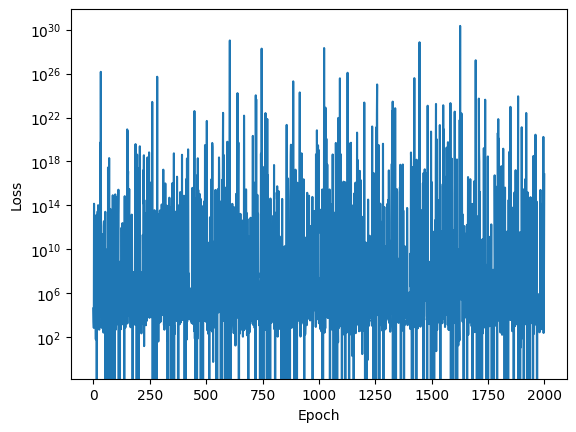

In [1]:
import matplotlib.pyplot as plt
import pyro
import torch
from pyro.distributions import Normal
from pyro.infer.autoguide import AutoNormal, init_to_mean
from utilities import inference


def generate_markov_data(x_init, a_param, std_epsilon, std_nu, total_time):
    """
    True generating process.
    """
    # Timeseries of latent state.
    l_x = torch.zeros(total_time)
    l_x[0] = x_init

    # Evolution and Measurement.
    for i_time in range(1, total_time):
        l_x[i_time] = a_param * l_x[i_time - 1]
        # mean_x = a_param * l_x[i_time - 1]
        # l_x[i_time] = Normal(mean_x, std_epsilon).sample()
        # In this kind of models we normally do not have measurements of
        # the initial state.
        # mean_y = l_x[i_time]
    l_y = Normal(l_x, std_nu).sample()

    return l_x, l_y


def model_markov(measurements, mean_a, std_a, x_init, std_epsilon, std_nu,
                 total_time):
    """
    True generating process.
    """
    # Timeseries of latent state.
    l_x = torch.zeros(total_time)
    l_x[0] = x_init
    
    # Timeseries of measurements.
    l_y = torch.zeros(total_time - 1)
    
    # Prior of evolution parameter.
    a_param = pyro.sample("a_param", Normal(mean_a, std_a))
    a_ = a_param.clone().detach()
    # Evolution and Measurement.
    for i_time in range(1, total_time):
        l_x[i_time] = a_ * l_x[i_time - 1]
        # mean_x = a_param * l_x[i_time - 1]
        # l_x[i_time] = pyro.sample(f"x_{i_time:03d}",
        #                           Normal(mean_x, std_epsilon))
        # In this kind of models we normally do not have measurements of
        # the initial state.
        # mean_y = l_x[i_time]
        # pyro.sample(f"y_{i_time:03d}", Normal(mean_y, std_nu),
        #             obs=measurements[i_time - 1])
    with pyro.plate("measurements", total_time):
        pyro.sample(f"y", Normal(l_x, std_nu),
                    obs=measurements)
    
    return l_x, l_y


X_INIT = torch.tensor(1.0)
A_TRUE = torch.tensor(0.9)
STD_EPSILON = torch.tensor(1e-3)
STD_NU = torch.tensor(1e-2)
TOTAL_TIME = 100
L_TIME = torch.arange(0, TOTAL_TIME)

# Plot measurements.
state, measurements = generate_markov_data(X_INIT, A_TRUE, STD_EPSILON,
                                           STD_NU, TOTAL_TIME)

plt.figure("Measurements")
plt.plot(L_TIME, measurements, label="Measurements")
plt.xlabel("Time")
plt.ylabel("Measurements (arb. units)")
plt.legend()

# Infer variational approximation to the posterior distribution of M.
guide = AutoNormal(model_markov, init_loc_fn=init_to_mean())
MEAN_A = torch.tensor(1.0)
STD_A = torch.tensor(3e-1)
model_args = {"measurements": measurements, "mean_a": MEAN_A, "std_a": STD_A,
              "x_init": X_INIT, "std_epsilon": STD_EPSILON, "std_nu": STD_NU,
              "total_time": TOTAL_TIME}
optim_args = {"lr": 1e-4}
N_STEPS = 2000
PRINT_EPOCH = 100

# torch.autograd.set_detect_anomaly(True)
inference(model_markov, guide, model_args, optim_args, n_steps=N_STEPS,
          print_epoch=PRINT_EPOCH)

# Print posterior parameters.
for key, val in pyro.get_param_store().items():
    print(79 * "=")
    print(f"{key} = {val}")
mu_mean_posterior = pyro.param("AutoNormal.locs.a_param")
std_mean_posterior = pyro.param("AutoNormal.scales.a_param")